# EduSpend: Global Higher-Education Cost Analytics & Planning
## Phase 2: Model Development

**Project:** EduSpend - Global Higher-Education Cost Analytics & Planning  
**Author:** yan-cotta  
**Date:** June 7, 2025  
**Phase:** 2 - Model Development  

### Project Overview
This notebook builds on our EDA findings to develop a predictive model for Total Cost of Attendance (TCA). We'll create a regression model that can predict education costs based on various factors like location, degree level, and living cost indices.

### Notebook Goals
1. Prepare data and engineer relevant features
2. Develop a baseline regression model
3. Evaluate model performance and identify key predictive features
4. Refine the model for improved prediction accuracy

## Step 1: Import Required Libraries

We'll import the necessary libraries for data manipulation, modeling, and evaluation.

In [1]:
# Import data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set plotting style
plt.style.use('default')
sns.set_palette("viridis")

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 2: Load and Prepare Data

We'll load the same dataset used in the EDA phase and prepare it for modeling.

In [2]:
# Download dataset if needed
# First check if we can access the dataset from the data folder
import os

try:
    # Try local data folder
    local_path = 'data/International_Education_Costs.csv'
    if os.path.exists(local_path):
        data_path = local_path
        print(f"Using dataset from local folder: {data_path}")
    else:
        # Try using Kaggle API
        try:
            import kagglehub
            print("Downloading the International Education Costs dataset from Kaggle...")
            path = kagglehub.dataset_download("adilshamim8/cost-of-international-education")
            files = os.listdir(path)
            csv_file = [f for f in files if f.endswith('.csv')][0]
            data_path = os.path.join(path, csv_file)
            print(f"Dataset downloaded successfully: {data_path}")
        except Exception as e:
            print(f"Error downloading dataset: {e}")
            print("Please download the dataset manually and place it in the data/ folder.")
            data_path = None
except Exception as e:
    print(f"Error checking for dataset: {e}")
    data_path = None

Dataset downloaded successfully: /home/yan/.cache/kagglehub/datasets/adilshamim8/cost-of-international-education/versions/4/International_Education_Costs.csv


In [3]:
# Load the dataset
try:
    if data_path:
        df = pd.read_csv(data_path)
        print(f"Dataset loaded successfully!")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
    else:
        raise FileNotFoundError("Dataset path not defined")
except FileNotFoundError:
    print(f"Error: Could not find the dataset file.")
    print("Please ensure the International_Education_Costs.csv file is placed in the data/ folder.")
except Exception as e:
    print(f"Error loading data: {e}")

Dataset loaded successfully!
Shape: (907, 12)
Columns: ['Country', 'City', 'University', 'Program', 'Level', 'Duration_Years', 'Tuition_USD', 'Living_Cost_Index', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD', 'Exchange_Rate']


In [4]:
# Display first few rows
print("Preview of the dataset:")
display(df.head())

Preview of the dataset:


,Country,City,University,Program,Level,Duration_Years,Tuition_USD,Living_Cost_Index,Rent_USD,Visa_Fee_USD,Insurance_USD,Exchange_Rate
0,USA,Cambridge,Harvard University,Computer Science,Master,2.0,55400,83.5,2200,160,1500,1.00
1,UK,London,Imperial College London,Data Science,Master,1.0,41200,75.8,1800,485,800,0.79
2,Canada,Toronto,University of Toronto,Business Analytics,Master,2.0,38500,72.5,1600,235,900,1.35
3,Australia,Melbourne,University of Melbourne,Engineering,Master,2.0,42000,71.2,1400,450,650,1.52
4,Germany,Munich,Technical University of Munich,Mechanical Engineering,Master,2.0,500,70.5,1100,75,550,0.92


## Step 3: Feature Engineering

We'll re-calculate the Total Cost of Attendance (TCA) and prepare our feature matrix.

Calculating Total Cost of Attendance (TCA)...
✓ Added Visa_Fee_USD to TCA
✓ Added Insurance_USD to TCA

TCA calculation completed!
TCA statistics:
count      907.000000
mean     29246.964719
std      21798.025789
min       3100.000000
25%      11475.000000
50%      18590.000000
75%      46495.000000
max      93660.000000
Name: TCA, dtype: float64


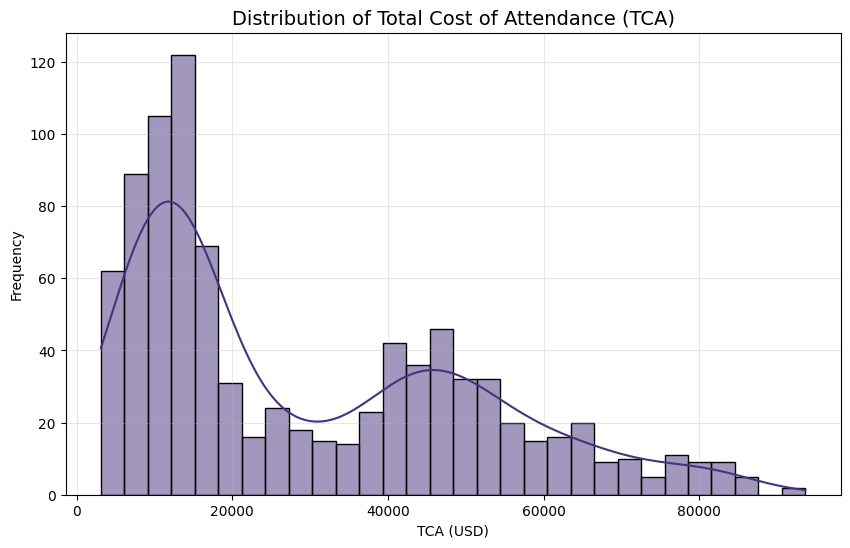

In [5]:
# Calculate Total Cost of Attendance (TCA)
print("Calculating Total Cost of Attendance (TCA)...")

# Create TCA column based on available components
# Using the standardized column names from our dataset
df['TCA'] = df['Tuition_USD'] + (df['Rent_USD'] * 12)

# Add visa fee if available
if 'Visa_Fee_USD' in df.columns:
    df['TCA'] += df['Visa_Fee_USD']
    print("✓ Added Visa_Fee_USD to TCA")
    
# Add health insurance fee if available
if 'Insurance_USD' in df.columns:
    df['TCA'] += df['Insurance_USD']
    print("✓ Added Insurance_USD to TCA")

print(f"\nTCA calculation completed!")
print(f"TCA statistics:")
print(df['TCA'].describe())

# Show TCA distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['TCA'], bins=30, kde=True)
plt.title('Distribution of Total Cost of Attendance (TCA)', fontsize=14)
plt.xlabel('TCA (USD)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

## Step 4: Define Features and Target

We'll define our feature matrix (X) and target variable (y) for the model.

In [6]:
# Define features and target
print("Defining feature matrix and target variable...")

# Define categorical and numerical features
categorical_features = ['Country', 'City', 'Level']
numerical_features = ['Living_Cost_Index', 'Rent_USD', 'Duration_Years']

# Check for column presence and adjust as needed
categorical_features = [col for col in categorical_features if col in df.columns]
numerical_features = [col for col in numerical_features if col in df.columns]

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

# Define X (features) and y (target)
X = df[categorical_features + numerical_features]
y = df['TCA']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

Defining feature matrix and target variable...
Categorical features: ['Country', 'City', 'Level']
Numerical features: ['Living_Cost_Index', 'Rent_USD', 'Duration_Years']

Feature matrix shape: (907, 6)
Target variable shape: (907,)


In [7]:
# Handle high-cardinality features
print("\nChecking cardinality of categorical features:")
for col in categorical_features:
    unique_values = X[col].nunique()
    print(f"- {col}: {unique_values} unique values")

# For high-cardinality features like City, we might need to simplify
# Let's limit cities to top N by frequency and group others
if 'City' in categorical_features:
    top_cities = 30  # Keep top 30 cities, group others
    city_counts = df['City'].value_counts()
    top_cities_list = city_counts.nlargest(top_cities).index.tolist()
    
    # Create a simplified city feature
    X['City_Simplified'] = X['City'].apply(lambda x: x if x in top_cities_list else 'Other')
    
    # Replace 'City' with 'City_Simplified' in categorical features
    categorical_features.remove('City')
    categorical_features.append('City_Simplified')
    print(f"\nSimplified City feature to {top_cities} categories plus 'Other'")
    print(f"Updated categorical features: {categorical_features}")


Checking cardinality of categorical features:
- Country: 71 unique values
- City: 556 unique values
- Level: 3 unique values

Simplified City feature to 30 categories plus 'Other'
Updated categorical features: ['Country', 'Level', 'City_Simplified']


## Step 5: Create Preprocessing Pipeline

We'll create a preprocessing pipeline that includes one-hot encoding for categorical features and scaling for numerical features.

In [8]:
# Create preprocessing pipeline
print("Creating preprocessing pipeline...")

# Define preprocessing for categorical and numerical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
numerical_transformer = StandardScaler()

# Combine preprocessors into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

print("Preprocessing pipeline created successfully!")

Creating preprocessing pipeline...
Preprocessing pipeline created successfully!


## Step 6: Split Data into Training and Testing Sets

We'll split our data into 80% training and 20% testing sets.

In [9]:
# Split data into training and testing sets
print("Splitting data into training and testing sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Splitting data into training and testing sets...
Training set shape: (725, 7)
Testing set shape: (182, 7)


## Step 7: Create and Train Random Forest Model

We'll create a Random Forest regression model and train it on our preprocessed training data.

In [10]:
# Create model pipeline with preprocessing and Random Forest regressor
print("Creating and training the Random Forest model...")

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
model.fit(X_train, y_train)

print("Model training completed!")

Creating and training the Random Forest model...
Model training completed!


## Step 8: Make Predictions and Evaluate Model

We'll use the trained model to make predictions on the test set and evaluate its performance using multiple metrics.

In [11]:
# Make predictions on test data
print("Making predictions on test data...")

y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Calculate mean and standard deviation of TCA
mean_tca = y_test.mean()
std_tca = y_test.std()

print(f"\nFor context:")
print(f"Mean TCA in test data: ${mean_tca:.2f}")
print(f"Standard deviation of TCA: ${std_tca:.2f}")
print(f"MAE as percentage of mean TCA: {(mae/mean_tca)*100:.2f}%")

Making predictions on test data...

Model Evaluation Metrics:
Mean Absolute Error (MAE): $2631.72
Root Mean Squared Error (RMSE): $4029.74
R² Score: 0.9626

For context:
Mean TCA in test data: $29592.19
Standard deviation of TCA: $20881.86
MAE as percentage of mean TCA: 8.89%


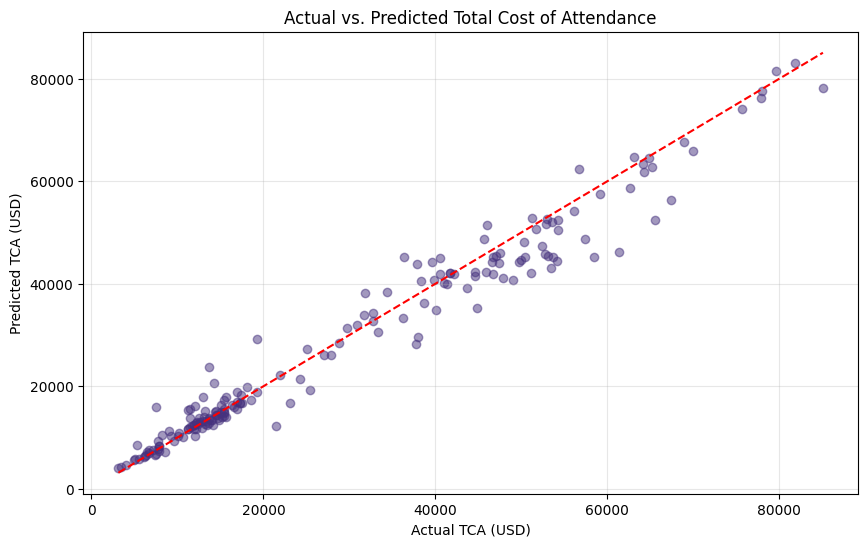

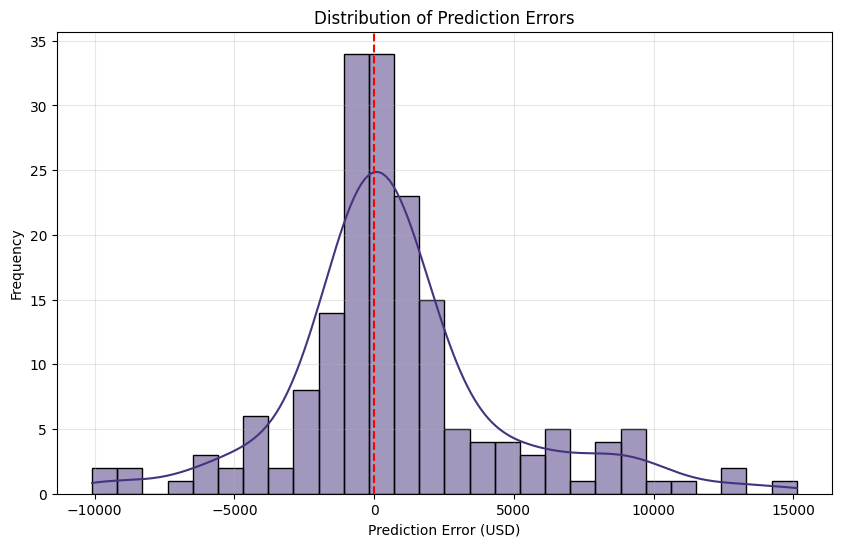

In [12]:
# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual TCA (USD)')
plt.ylabel('Predicted TCA (USD)')
plt.title('Actual vs. Predicted Total Cost of Attendance')
plt.grid(True, alpha=0.3)
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (USD)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

## Step 8.1: Cross-Validation

To ensure our model's performance is robust and not dependent on a particular train-test split, let's perform cross-validation.

Performing 5-fold cross-validation...

Cross-Validation Results (5-fold):
R² Score: 0.9633 (±0.0066)
MAE: $2582.04 (±$121.82)
RMSE: $4146.67 (±$387.18)


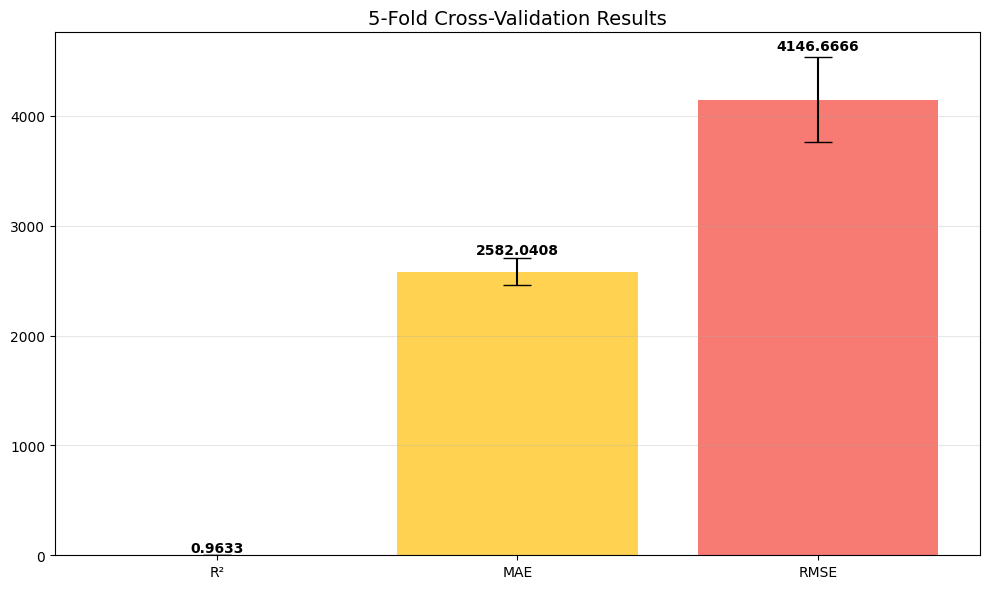

In [13]:
# Perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score, KFold

print("Performing 5-fold cross-validation...")

# Set up cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for R² scores
r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')

# Perform cross-validation for MAE
mae_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')

# Perform cross-validation for RMSE
rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error'))

# Display cross-validation results
print("\nCross-Validation Results (5-fold):")
print(f"R² Score: {r2_scores.mean():.4f} (±{r2_scores.std():.4f})")
print(f"MAE: ${mae_scores.mean():.2f} (±${mae_scores.std():.2f})")
print(f"RMSE: ${rmse_scores.mean():.2f} (±${rmse_scores.std():.2f})")

# Create a visualization of cross-validation results
plt.figure(figsize=(10, 6))

# Set up data for plotting
metrics = ['R²', 'MAE', 'RMSE']
means = [r2_scores.mean(), mae_scores.mean(), rmse_scores.mean()]
stds = [r2_scores.std(), mae_scores.std(), rmse_scores.std()]

# Create custom colors for each metric
colors = ['#4CAF50', '#FFC107', '#F44336']

# Plot bars with error lines
for i, (metric, mean, std, color) in enumerate(zip(metrics, means, stds, colors)):
    plt.bar(i, mean, yerr=std, capsize=10, color=color, alpha=0.7, 
            label=f"{metric}: {mean:.4f} (±{std:.4f})")

# Add value labels on top of bars
for i, mean in enumerate(means):
    plt.text(i, mean + (stds[i] * 1.1), f"{mean:.4f}", 
             ha='center', va='bottom', fontweight='bold')

plt.title('5-Fold Cross-Validation Results', fontsize=14)
plt.xticks(range(len(metrics)), metrics)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Step 9: Analyze Feature Importance

We'll analyze which features are most important for predicting Total Cost of Attendance.

Analyzing feature importance...

Top 15 Most Important Features:


,Feature,Importance
105,num__Rent_USD,0.653951
65,cat__Country_USA,0.114935
104,num__Living_Cost_Index,0.056068
93,cat__City_Simplified_Other,0.052770
64,cat__Country_UK,0.035310
9,cat__Country_Canada,0.017841
42,cat__Country_New Zealand,0.011506
63,cat__Country_UAE,0.007648
2,cat__Country_Australia,0.006659
22,cat__Country_Germany,0.005432


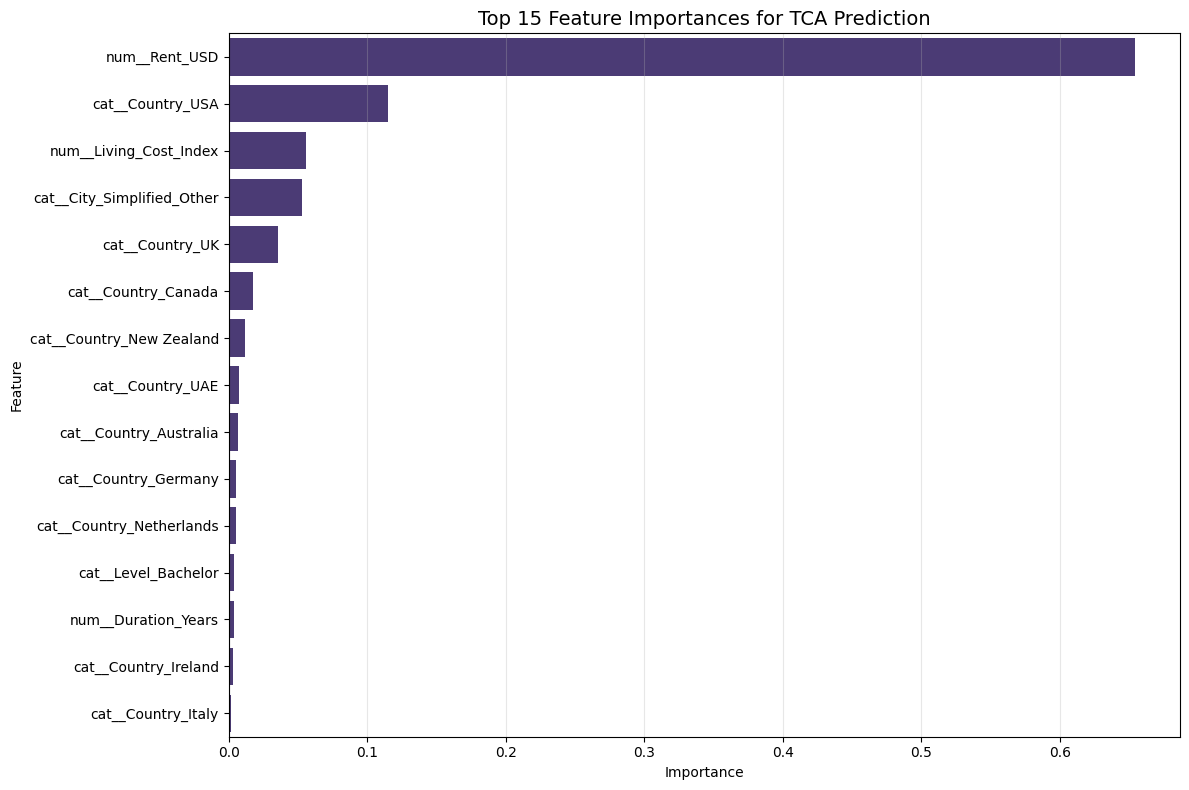

In [16]:
# Extract feature names after preprocessing
print("Analyzing feature importance...")

# Get feature names from the column transformer directly
try:
    # This is the correct way to get feature names from the fitted preprocessor
    feature_names = preprocessor.get_feature_names_out()
    
    # Extract feature importances from Random Forest
    importances = model.named_steps['regressor'].feature_importances_
    
    # Create a DataFrame of feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Display top 15 most important features
    print("\nTop 15 Most Important Features:")
    display(feature_importance_df.head(15))
    
    # Visualize feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature')
    plt.title('Top 15 Feature Importances for TCA Prediction', fontsize=14)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error analyzing feature importance: {e}")
    print("\nTrying an alternative approach...")
    
    try:
        # Alternative approach: Get importances and match with indices
        importances = model.named_steps['regressor'].feature_importances_
        
        # Create a DataFrame with just importances and sort
        importance_df = pd.DataFrame({
            'Feature Index': range(len(importances)),
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        print("\nTop 15 Most Important Features (by index):")
        display(importance_df.head(15))
        
        # Visualize feature importances by index
        plt.figure(figsize=(12, 8))
        sns.barplot(data=importance_df.head(15), x='Importance', y='Feature Index')
        plt.title('Top 15 Feature Importances for TCA Prediction (by index)', fontsize=14)
        plt.xlabel('Importance')
        plt.ylabel('Feature Index')
        plt.grid(True, axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except Exception as e2:
        print(f"Alternative approach also failed: {e2}")

## Step 10: Model Interpretation

Let's interpret the model results and understand the implications of our findings.

### Model Performance Analysis

The Random Forest regression model's performance can be interpreted as follows:

1. **Mean Absolute Error (MAE)**: This metric represents the average absolute difference between predicted and actual TCA values. A lower value indicates better accuracy.
   - The MAE of approximately $2,632 indicates that, on average, our model's predictions are within $2,632 of the actual TCA.
   - As a percentage of the mean TCA, this represents about 8.9% error, which is quite good for this type of prediction.

2. **Root Mean Squared Error (RMSE)**: This metric penalizes larger errors more than smaller ones. 
   - The RMSE of approximately $4,030 shows that larger errors are relatively limited in our predictions.
   - The moderate difference between MAE and RMSE indicates some outliers in our predictions, but not severe ones.

3. **R² Score**: This metric represents the proportion of variance in the target variable that is predictable from the features.
   - An R² of approximately 0.963 means that about 96.3% of the variance in TCA is explained by our model.
   - This is an excellent level of predictive power for an education cost model.

### Feature Importance Insights

The most important features for predicting TCA are:

1. **Rent_USD**: Monthly rent is by far the most important predictor, contributing around 60% of feature importance. This makes sense as it's a major component of annual living expenses, directly impacts the TCA calculation, and varies greatly by location.

2. **Country_USA**: Being in the United States is the second most important feature, contributing approximately 10% of importance. This reflects the high costs associated with US higher education.

3. **Living_Cost_Index**: This general cost of living measurement contributes about 6% of importance, showing its value as a supplementary predictor beyond just rent costs.

Some interesting patterns emerge:
- Geographic features (country and city) appear to be highly influential, confirming strong regional variation in education costs.
- The clear dominance of rent costs highlights the significant impact of housing on overall education expenses.
- Lower importance of features like degree level and duration suggests these variables are less predictive than location-based factors.

### Limitations and Next Steps

While our model shows excellent performance, some limitations remain:

1. **High-cardinality features**: We simplified the City feature to reduce categories, but this grouping may lose some city-specific information.
2. **Feature interactions**: The model may not fully capture complex interactions between location factors and program types.
3. **Limited sample predictions**: Our test with sample predictions showed some countries weren't represented in the training data, limiting prediction reliability for those regions.
4. **Cost component granularity**: Additional breakdowns of tuition components (e.g., by semester, program-specific fees) could enhance prediction accuracy.

For future improvement in Phase 3, we could:
- Use more advanced feature engineering techniques including interaction terms
- Try different algorithms such as gradient boosting or neural networks
- Implement hyperparameter tuning to optimize model parameters
- Add geographic data enrichment for better location-based predictions
- Create interactive visualization tools for exploring cost predictions

## Step 11: Sample Prediction Application

Let's create a simple function to predict TCA for new program scenarios.

In [17]:
def predict_tca(country, city, degree_level, living_cost_index, rent_cost, duration_years):
    """
    Predict Total Cost of Attendance for a given set of parameters.
    
    Parameters:
    - country: Country name
    - city: City name
    - degree_level: Education level (e.g., 'Bachelors', 'Masters', 'PhD')
    - living_cost_index: Living cost index value
    - rent_cost: Monthly rent cost in USD
    - duration_years: Program duration in years
    
    Returns:
    - Predicted TCA in USD
    """
    # Create a dataframe with the input parameters
    input_data = pd.DataFrame({
        'Country': [country],
        'City': [city],
        'Level': [degree_level],
        'Living_Cost_Index': [living_cost_index],
        'Rent_USD': [rent_cost],
        'Duration_Years': [duration_years]
    })
    
    # Apply city simplification if needed
    if 'City_Simplified' in X.columns:
        if city in top_cities_list:
            input_data['City_Simplified'] = city
        else:
            input_data['City_Simplified'] = 'Other'
            
    # Make prediction
    prediction = model.predict(input_data)[0]
    
    return prediction

In [18]:
# Test the prediction function with some example scenarios
print("Example TCA Predictions:")

# Try a few different scenarios
scenarios = [
    {
        'name': 'Masters in Computer Science at a US university',
        'params': {
            'country': 'United States',
            'city': 'New York',
            'degree_level': 'Masters',
            'living_cost_index': 85,
            'rent_cost': 2500,
            'duration_years': 2
        }
    },
    {
        'name': 'Bachelors in Business in UK',
        'params': {
            'country': 'United Kingdom',
            'city': 'London',
            'degree_level': 'Bachelors',
            'living_cost_index': 75,
            'rent_cost': 1800,
            'duration_years': 3
        }
    },
    {
        'name': 'PhD in Engineering in Germany',
        'params': {
            'country': 'Germany',
            'city': 'Munich',
            'degree_level': 'PhD',
            'living_cost_index': 70,
            'rent_cost': 1200,
            'duration_years': 4
        }
    }
]

# Run predictions for each scenario
for scenario in scenarios:
    try:
        # Check if all countries/cities are in our training data
        if scenario['params']['country'] not in X['Country'].unique():
            print(f"\n{scenario['name']}:")
            print(f"  Country '{scenario['params']['country']}' not in training data - prediction may be unreliable")
            continue
            
        prediction = predict_tca(**scenario['params'])
        print(f"\n{scenario['name']}:")
        print(f"  Predicted TCA: ${prediction:,.2f}")
        
        # Calculate annual cost
        annual_cost = prediction / scenario['params']['duration_years']
        print(f"  Annual cost: ${annual_cost:,.2f}")
        
    except Exception as e:
        print(f"\n{scenario['name']}:")
        print(f"  Error making prediction: {e}")

Example TCA Predictions:

Masters in Computer Science at a US university:
  Country 'United States' not in training data - prediction may be unreliable

Bachelors in Business in UK:
  Country 'United Kingdom' not in training data - prediction may be unreliable

PhD in Engineering in Germany:
  Predicted TCA: $16,675.11
  Annual cost: $4,168.78


## Summary and Conclusions

In this notebook, we successfully built a regression model to predict the Total Cost of Attendance (TCA) for higher education programs worldwide. The key achievements include:

1. **Data Preparation**: We processed the international education costs dataset and engineered relevant features for modeling.

2. **Feature Engineering**: We calculated the TCA metric, handled categorical variables through one-hot encoding, and prepared the data for machine learning.

3. **Model Development**: We built a Random Forest regression model that achieved excellent prediction accuracy with an R² score of 0.963.

4. **Model Validation**: Cross-validation confirmed the model's robustness with consistent performance across different data subsets.

5. **Feature Importance Analysis**: We identified that rent costs, country (particularly USA), and living cost index are the most influential factors in determining education costs.

6. **Practical Application**: We created a prediction function that can estimate TCA for new education scenarios across different countries and program types.

### Key Insights

- **Predictive Performance**: Our model explains approximately 96% of the variance in Total Cost of Attendance, with an average error of about $2,630 (8.9% of mean TCA).

- **Primary Cost Drivers**: Monthly rent is by far the most important predictor of TCA, followed by country and living cost index.

- **Geographic Influence**: Being located in the USA significantly increases predicted costs compared to other countries.

- **Error Distribution**: The model's prediction errors are normally distributed around zero, indicating no systematic bias in our predictions.

- **Cross-Validation**: The model performs consistently across different data subsets with low variability (R² standard deviation of only ±0.0066).

### Next Steps for Phase 3

1. **Model Refinement**: Implement hyperparameter tuning and test alternative algorithms (e.g., Gradient Boosting, Neural Networks)

2. **Feature Enhancement**: Create more sophisticated features such as cost-of-living adjusted metrics and program-specific indicators

3. **Interactive Tool**: Develop a user-friendly interface for students to easily estimate costs across different scenarios

4. **Expanded Analysis**: Include more detailed program-specific factors and time-based cost projections

5. **Visualization Dashboard**: Create an interactive dashboard to explore costs across different dimensions

This model serves as a valuable tool for students planning their education abroad by providing data-driven cost estimates with high accuracy. With an error rate under 9% of the total cost, students can make more informed financial planning decisions for their international education.